# Training script for review generation model

Based on the article: https://towardsdatascience.com/how-to-fine-tune-gpt-2-for-text-generation-ae2ea53bc272

## Install Hugging Face Transformers and Datasets library

In [1]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 2.6 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 32.9 MB/s 
     |████████████████████████████████| 636 kB 49.7 MB/s 
     |████████████████████████████████| 895 kB 49.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 542 kB 4.3 MB/s 
     |████████████████████████████████| 118 kB 8.9 MB/s 
     |████████████████████████████████| 243 kB 8.7 MB/s 
     |████████████████████████████████| 76 kB 3.8 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


## Mount Google Drive for loading data and saving model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = '/content/drive/My Drive/dataset/Magazine_Subscriptions.json'

## Import necessay libraries

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from transformers import GPT2LMHeadModel, GPT2Tokenizer

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup

from tqdm import tqdm, trange

## Load data to pandas dataframe

In [5]:
df = pd.read_json(data, lines=True)
df.dropna(subset=["reviewText"], inplace=True)
reviews = df.reviewText.copy()

In [6]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5,9,False,"11 8, 2001",AH2IFH762VY5U,B00005N7P0,ted sedlmayr,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME",1005177600,NaN,NaN
1,5,9,False,"10 31, 2001",AOSFI0JEYU4XM,B00005N7P0,Amazon Customer,Thank god this is not a Ziff Davis publication...,The straight scoop,1004486400,NaN,NaN
2,3,14,False,"03 24, 2007",A3JPFWKS83R49V,B00005N7OJ,Bryan Carey,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone",1174694400,{'Format:': ' Print Magazine'},NaN
3,5,13,False,"11 10, 2006",A19FKU6JZQ2ECJ,B00005N7OJ,Patricia L. Porada,This beautiful magazine is in itself a work of...,THE DISCERNING READER,1163116800,{'Format:': ' Print Magazine'},NaN
4,5,NaN,True,"07 14, 2014",A25MDGOMZ2GALN,B00005N7P0,Alvey,A great read every issue.,Five Stars,1405296000,NaN,NaN


In [7]:
print(f"Number of records in this dataset: {df.shape[0]}")

Number of records in this dataset: 89656


In [8]:
#Get the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1049 > 1024). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


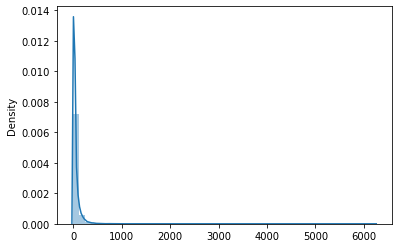

In [9]:
doc_lengths = []

for review in reviews:

    # get rough token count distribution
    tokens = tokenizer.encode(review)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

## Create training set

In [10]:
class UserReviews(Dataset):  
    def __init__(self, control_code, truncate=False, gpt2_type="gpt2", max_length=1024):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.review = []

        for row in df['reviewText']:
          self.review.append(torch.tensor(
                self.tokenizer.encode(f"<|{control_code}|>{row[:max_length]}<|endoftext|>")
            ))
        if truncate:
            self.review = self.review[:20000]
        self.review_count = len(self.review)
        
    def __len__(self):
        return self.review_count

    def __getitem__(self, item):
        return self.review[item]
    
dataset = UserReviews('title', truncate=True, gpt2_type="gpt2")

In [11]:
#Accumulated batch size (since GPT2 is so big)
def pack_tensor(new_tensor, packed_tensor, max_seq_len):
    if packed_tensor is None:
        return new_tensor, True, None
    if new_tensor.size()[1] + packed_tensor.size()[1] > max_seq_len:
        return packed_tensor, False, new_tensor
    else:
        packed_tensor = torch.cat([new_tensor, packed_tensor[:, 1:]], dim=1)
        return packed_tensor, True, None

In [12]:
def train(
    dataset, model, tokenizer,
    batch_size=16, epochs=5, lr=2e-5,
    max_seq_len=400, warmup_steps=200,
    gpt2_type="gpt2", output_dir=".", output_prefix="checkpoint",
    test_mode=False,save_model_on_epoch=False,
):
    acc_steps = 100
    device=torch.device("cuda")
    model = model.cuda()
    model.train()

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1
    )

    train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    loss=0
    accumulating_batch_count = 0
    input_tensor = None

    for epoch in range(epochs):

        print(f"Training epoch {epoch}")
        print(loss)
        for idx, entry in tqdm(enumerate(train_dataloader)):
            (input_tensor, carry_on, remainder) = pack_tensor(entry, input_tensor, 768)

            if carry_on and idx != len(train_dataloader) - 1:
                continue

            input_tensor = input_tensor.to(device)
            outputs = model(input_tensor, labels=input_tensor)
            loss = outputs[0]
            loss.backward()

            if (accumulating_batch_count % batch_size) == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                model.zero_grad()

            accumulating_batch_count += 1
            input_tensor = None
        if save_model_on_epoch:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch}.pt"),
            )
    return model

In [13]:
model = train(dataset, model, tokenizer)

Training epoch 0
0


20000it [10:31, 31.68it/s]


Training epoch 1
tensor(3.4460, device='cuda:0', grad_fn=<NllLossBackward>)


20000it [10:31, 31.66it/s]


Training epoch 2
tensor(2.8349, device='cuda:0', grad_fn=<NllLossBackward>)


20000it [10:30, 31.73it/s]


Training epoch 3
tensor(3.4670, device='cuda:0', grad_fn=<NllLossBackward>)


20000it [10:29, 31.79it/s]


Training epoch 4
tensor(3.3766, device='cuda:0', grad_fn=<NllLossBackward>)


20000it [10:30, 31.72it/s]


## Load pre-finetuned model for comparison

In [14]:
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

In [17]:
def generate_text(model, prompt, max_suggestion_length=50, top_p=0.8, num_return_sequences=3):
    device = 'cuda'
    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0).to(device)
    prompt_size = generated.shape[1]
    model = model.to(device)
    model.eval()
    sample_outputs = model.generate(
        generated,
        do_sample=True,
        top_k=50,
        max_length=max_suggestion_length + prompt_size,
        top_p=top_p,
        num_return_sequences=num_return_sequences
    )

    results = [tokenizer.decode(output, skip_special_tokens=True) for output in sample_outputs]
    return results

In [19]:
test_prompt = "This magazine is quite"
prefinetuned_output = generate_text(gpt2_model, test_prompt, num_return_sequences=1)[0]
finetuned_output = generate_text(model, test_prompt, num_return_sequences=1)[0]
print(f"Query: {test_prompt}")
print(f"Output before finetuning: {prefinetuned_output}")
print(f"Output after finetuning: {finetuned_output}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Query: This magazine is quite
Output before finetuning: This magazine is quite large, it is so large that even a magazine of this size would be considered inadequate for reading a book.

There are two ways to view this book. You can use the first. You can view it as a book with a large,
Output after finetuning: This magazine is quite expensive and can be hard to find in many stores, but if you want to buy the best of both worlds, this is the magazine for you.


## Save model to drive directory

In [ ]:
#model.save_pretrained('/content/drive/My Drive/models/GPT2-finetuned')